In [14]:
import torch
from glob import glob
from pathlib import Path
import numpy as np
from tqdm import tqdm
import cv2
from cnn4 import CNN4
from datamodule import Datamodule
from params import LocationConfig, TrainingConfig
from torch.nn import functional as F
import torchvision.transforms as transforms
from torchsummary import summary

In [15]:
cnn4 = CNN4(lr=TrainingConfig.lr, batch_norm=True, sigmoid=True)
summary(cnn4.cuda(), (208,208, 1) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 208, 208]             160
       BatchNorm2d-2         [-1, 16, 208, 208]              32
              ReLU-3         [-1, 16, 208, 208]               0
           Dropout-4         [-1, 16, 208, 208]               0
         MaxPool2d-5         [-1, 16, 104, 104]               0
            Conv2d-6         [-1, 32, 104, 104]           4,640
       BatchNorm2d-7         [-1, 32, 104, 104]              64
           Dropout-8         [-1, 32, 104, 104]               0
         MaxPool2d-9           [-1, 32, 52, 52]               0
           Conv2d-10           [-1, 64, 52, 52]          18,496
      BatchNorm2d-11           [-1, 64, 52, 52]             128
          Dropout-12           [-1, 64, 52, 52]               0
        MaxPool2d-13           [-1, 64, 26, 26]               0
           Conv2d-14          [-1, 128,

In [4]:
checkpoints_dir = Path(LocationConfig.checkpoints_dir)
list_of_checkpoints = list(checkpoints_dir.glob("*.ckpt"))
latest_checkpoint_path = max(list_of_checkpoints, key=lambda p: p.stat().st_ctime)

cnn4 = CNN4(lr=TrainingConfig.lr, batch_norm=TrainingConfig.batch_norm, sigmoid=TrainingConfig.sigmoid)\
    .load_from_checkpoint(checkpoint_path=latest_checkpoint_path)
cnn4.eval();
cnn4.state_dict()['conv.conv_0.weight'][0]

TypeError: __init__() missing 2 required positional arguments: 'batch_norm' and 'sigmoid'

In [16]:
train_data_path = Path(LocationConfig.new_data + 'train')
test_data_path = Path(LocationConfig.new_data + 'test')
dm = Datamodule(
        batch_size=TrainingConfig.batch_size,
        train_dir=train_data_path,
        val_dir=test_data_path,
        )
# dm.setup(val_only=True)
dm.setup()

file: new_data/train/train.pickle
file: new_data/test/test.pickle


  0%|          | 0/88 [00:00<?, ?it/s]

torch.Size([32, 208, 208, 1])


  0%|          | 0/88 [00:00<?, ?it/s]


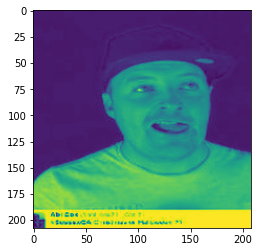

In [19]:
from matplotlib import pyplot as plt
for batch in tqdm(dm.val_dataloader()):
    print(batch['normalized'].shape)
    plt.imshow(batch['normalized'][0])
    break

In [12]:
acc_class_global_12 = np.zeros(5)
acc_class_global_47 = np.zeros(5)
i=0
for batch in tqdm(dm.val_dataloader()):
    X, Y = batch['normalized'], batch['label']
#     normalize = transforms.Normalize((X.mean()), (X.std()))
#     X = normalize(X)
    Y_pred = cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    
    Y_pred_47 = np.where(Y_pred > 4/7, 1, 0)
    acc_class_47 = np.sum(Y_pred_47 == np.array(Y), axis=0) / len(Y)
    acc_class_global_47 += acc_class_47
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())
acc_class_global_47 /= i
print('4/7')
print(acc_class_global_47)
print(acc_class_global_47.mean())

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

[0.  0.5 0.5 0.5 0.5]
0.4


In [14]:
for batch in dm.val_dataloader():
    X, Y = batch['normalized'], batch['label']
#     normalize = transforms.Normalize((X.mean()), (X.std()))
#     X = normalize(X)
    Y_pred = cnn4(X)
    # Y_pred = np.where(Y_pred > limit, 1, 0)
    print(Y_pred[0:5])
    Y_pred = np.where(Y_pred > 1/2, 1, 0)
    print(Y_pred[0:5])
    print(Y[0:5])
    break

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

[0.  0.5 0.5 0.5 0.5]
0.4
